In [ ]:
!pip install vit
!pip install tensorflow-addons

In [ ]:
import tensorflow as tf
from vit import ViTClassfier
from utils import plot_grid_ds, AttrDict, BalancedSparseCategoricalAccuracy

### 1. Exploratory Data Analysis

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


path = Path("/content/drive/MyDrive/dataset/")
img_as_jpg = list(path.glob(r"*/*.jpg"))

# Counts the number of each categories in the dataset
file_count = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],img_as_jpg))
glioma = file_count.count('glioma_tumor')
meningioma = file_count.count('meningioma_tumor')
no_tum = file_count.count('no_tumor')
pituitary = file_count.count('pituitary_tumor')

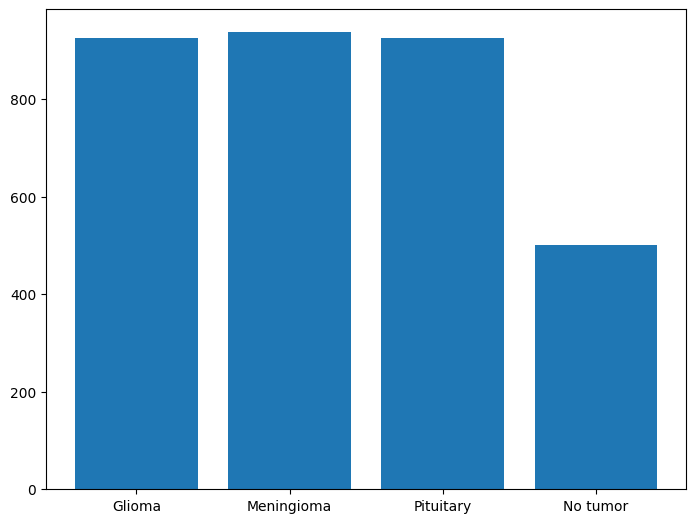

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
labels = ['Glioma','Meningioma', 'Pituitary', 'No tumor']
count_train = [glioma, meningioma, pituitary, no_tum]
ax.bar(labels, count_train)
plt.show()

In [6]:
train = pd.concat([pd.Series(img_as_jpg,name="image").apply(str),pd.Series(file_count, name="type")],axis=1)
train = train.sample(frac=1).reset_index(drop=True)
print(np.shape(train))

(3287, 2)


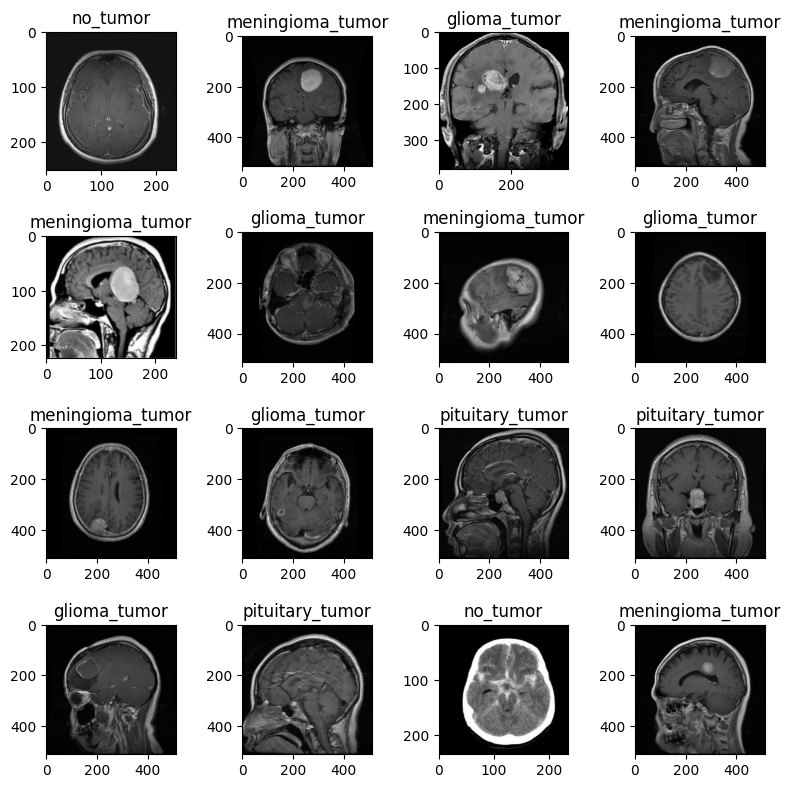

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
fig.tight_layout()
counter = 0
for ax in axes.reshape(-1):
    ax.imshow(plt.imread(train["image"][counter]))
    ax.set_title(train["type"][counter])
    plt.rcParams["axes.grid"] = False
    counter = counter+1

## 2. Model

In [11]:
hparams = AttrDict(
    image_size=(128, 128, 3),
    n_classes=4,
    batch_size=64,
)

ds = tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/dataset/", image_size=hparams.image_size[:-1], batch_size=hparams.batch_size)
train_split = round(0.8 * ds.cardinality().numpy())
train_ds = ds.take(train_split); train_ds.class_names = ds.class_names
validation_ds = ds.skip(train_split); validation_ds.class_names = ds.class_names

Found 3287 files belonging to 4 classes.


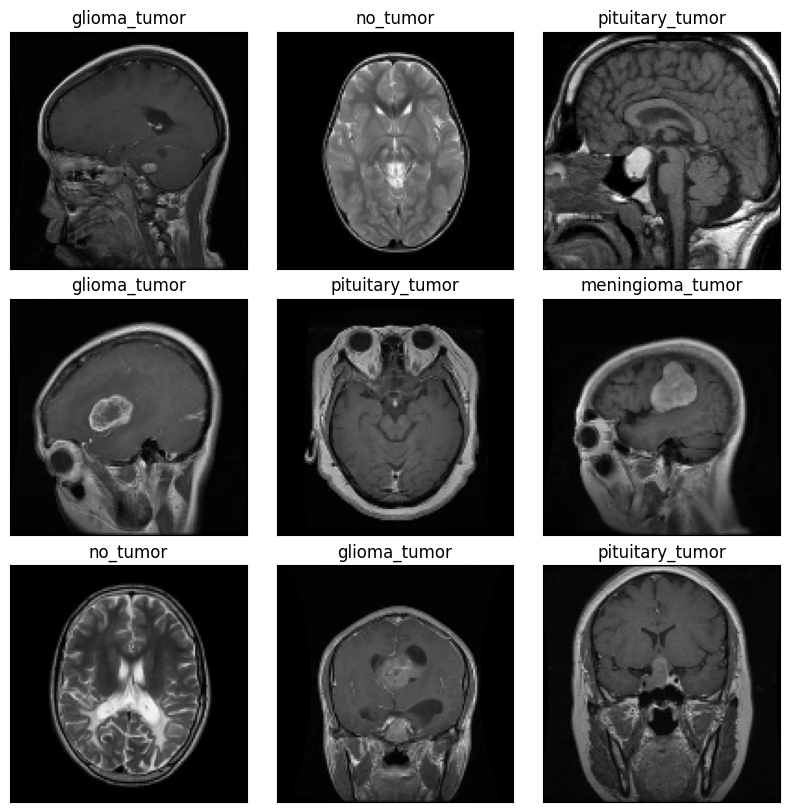

In [12]:
_ = plot_grid_ds(train_ds)

In [13]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = ViTClassfier(hparams.image_size, hparams.n_classes)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy", BalancedSparseCategoricalAccuracy()]
    )

In [ ]:
model.fit(train_ds, epochs=10, validation_data=validation_ds)

Epoch 1/10
42/42 [==============================] - 480s 11s/step - loss: 5.3762 - accuracy: 0.4929 - balanced_sparse_categorical_accuracy: 0.4814 - val_loss: 0.6816 - val_accuracy: 0.7596 - val_balanced_sparse_categorical_accuracy: 0.7475
Epoch 2/10
42/42 [==============================] - 116s 3s/step - loss: 0.6879 - accuracy: 0.7236 - balanced_sparse_categorical_accuracy: 0.7249 - val_loss: 0.5625 - val_accuracy: 0.7780 - val_balanced_sparse_categorical_accuracy: 0.7506
Epoch 3/10
42/42 [==============================] - 118s 3s/step - loss: 0.5371 - accuracy: 0.7853 - balanced_sparse_categorical_accuracy: 0.7856 - val_loss: 0.4453 - val_accuracy: 0.8214 - val_balanced_sparse_categorical_accuracy: 0.8247
Epoch 4/10
42/42 [==============================] - 128s 3s/step - loss: 0.3994 - accuracy: 0.8467 - balanced_sparse_categorical_accuracy: 0.8493 - val_loss: 0.3881 - val_accuracy: 0.8614 - val_balanced_sparse_categorical_accuracy: 0.8713
Epoch 5/10
42/42 [=========================

## 3. Results

In [ ]:
_ = plot_grid_ds(validation_ds, size=(4, 4), model=model, figsize= (20,20))

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

X, y_true = list(zip(*[(X, y) for (X, y) in validation_ds.unbatch().as_numpy_iterator()]))
y_hat = model.predict_on_batch(np.array(X)).argmax(axis=-1)
mat = confusion_matrix(y_true, y_hat)
mat

In [ ]:
from sklearn.metrics import balanced_accuracy_score

acc = balanced_accuracy_score(y_true, y_hat)
print(f"Final accuracy on validation set : {acc:.3f}")

In [ ]:
model.save("models/ViT_on_10_epochs.model")

In [ ]:
!pip install gradio
import gradio as gr
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

In [ ]:
def predict_image(image):
    resized_image = cv2.resize(image, (128, 128))
    y_hat = model.predict_on_batch(np.array([resized_image])).argmax(axis=-1)
    if(y_hat == 1 ):return "meningioma tumor"
    if(y_hat == 2 ):return "no tumor"
    if(y_hat == 3 ):return "pituitary tumor"
    if(y_hat == 4 ):return "glioma_tumor"
    return "Unable to identify ..."

In [ ]:
image_input = gr.Image()
output_text = gr.Text(label="Predicted Label")
gr.Interface(fn=predict_image, inputs=image_input, outputs=output_text, title="Image Classifier").launch(inline=True,debug=True)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ff2086071910e34517.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
